##### Importing the Necessary Libraries

In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold,GridSearchCV 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier      
from sklearn.ensemble import GradientBoostingClassifier                     

##### Importing the training dataset

In [2]:
path= r'C:\Users\HP\Desktop\project_intern\data\Kaggle_Training_Dataset_v2.csv'         # Use the path of your downloaded dataset for avoiding errors
train_data= pd.read_csv(path,index_col=0)
train_data.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_9296\1273359165.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data= pd.read_csv(path,index_col=0)


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


##### Importing the test dataset

In [3]:
path= r'C:\Users\HP\Desktop\project_intern\data\Kaggle_Test_Dataset_v2.csv'             # Use the path of your downloaded dataset for avoiding errors
test_data= pd.read_csv(path,index_col=0)
test_data.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_9296\2202915465.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data= pd.read_csv(path,index_col=0)


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


##### Feature Engineering on the Train Dataset

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer

train_data= train_data.drop(['forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)    #Avoiding Multicollinearity

num_cols= [0,1,2,3,4,5,7,8,9]               #The index number of each column is required for transformations
cat_cols= [6,10,11,12,13,14,15]

# To handle missing values and transform data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('power_transform', PowerTransformer())
        ]), num_cols),

        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='if_binary'))
        ]), cat_cols)
    ],
    remainder='passthrough' 
)                                                         

train_data= preprocessor.fit_transform(train_data)
train_data= pd.DataFrame(train_data)

X= train_data.drop([15],axis=1)                            
y= train_data[15]

skf= StratifiedKFold(random_state=42,shuffle=True)                  #Stratified KFold cross val splits for hyperparamter tuning and for getting mean train scores
scaler= StandardScaler()

##### Feature Engineering on the Test Dataset

In [5]:
test_data= test_data.drop(['forecast_6_month', 'forecast_9_month','sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)                                                          

test_data= preprocessor.transform(test_data)
test_data= pd.DataFrame(test_data)

X_test= test_data.drop([15],axis=1)                            
y_test= test_data[15]

##### GridSearchCV for Logistic Model with Undersampling

In [6]:
#Using PR_AUC as the scoring metric during GridSearchCV

import warnings
warnings.filterwarnings('ignore')                                                       #Training 5min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2','elasticnet'],
    'classifier__solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__l1_ratio':[0,1,0.5]
}

grid_lr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_lr.fit(X,y)
log_model= grid_lr.best_estimator_

best_index= grid_lr.best_index_
results = pd.DataFrame(grid_lr.cv_results_)

print("Best PR AUC Score:", grid_lr.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's Roc score             
print("Best Parameters:", grid_lr.best_params_)

Best PR AUC Score: 0.07110806658859507
Best ROC AUC Score: 0.8892034233910471
Best Parameters: {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}


In [7]:
#Using ROC_AUC as the scoring metric during GridSearchCV

import warnings
warnings.filterwarnings('ignore')                                                           # Train time 5min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2','elasticnet'],
    'classifier__solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__l1_ratio':[0,1,0.5]
}

grid_lr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_lr.fit(X,y)
log_model= grid_lr.best_estimator_

best_index= grid_lr.best_index_
results = pd.DataFrame(grid_lr.cv_results_)

print("Best ROC AUC Score:", grid_lr.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_lr.best_params_)

Best ROC AUC Score: 0.8892034233910471
Best PR AUC Score: 0.07110806658859507
Best Parameters: {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}


Both gave the same results!!!  

So the final parameters for logistic model along with smote would be {'classifier__C': 10, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2','classifier__solver': 'newton-cholesky'} 

The performance on test data for Logistic Model with undersampling are as follows:-

Logistic Test ROC Score:  0.8658846753790618
Logistic Test PR Score:  0.06364236065928747
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83    239388
         1.0       0.03      0.89      0.06      2688

    accuracy                           0.72    242076
   macro avg       0.52      0.80      0.45    242076
weighted avg       0.99      0.72      0.82    242076



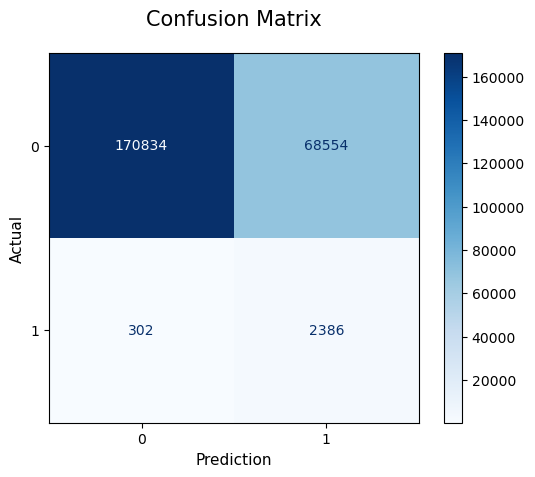

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= log_model.predict_proba(X_test_scaled)[:, 1]
y_predict= log_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Logistic Test ROC Score: ',roc_auc)
print('Logistic Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### LinearSVC

In [9]:
from sklearn.svm import LinearSVC               # Training time 20s

svm_model = LinearSVC(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    X_train_scaled= scaler.fit_transform(X_train)
    X_val_scaled= scaler.transform(X_val)

    svm_model.fit(X_train_scaled,y_train)
    y_pred= svm_model.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8589127854576327
PR_score: 0.06336975946129979


SVC Test ROC Score:  0.8460078517058778
SVC Test PR Score:  0.07948526912517083
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.00      0.00      0.00      2688

    accuracy                           0.99    242076
   macro avg       0.49      0.50      0.50    242076
weighted avg       0.98      0.99      0.98    242076



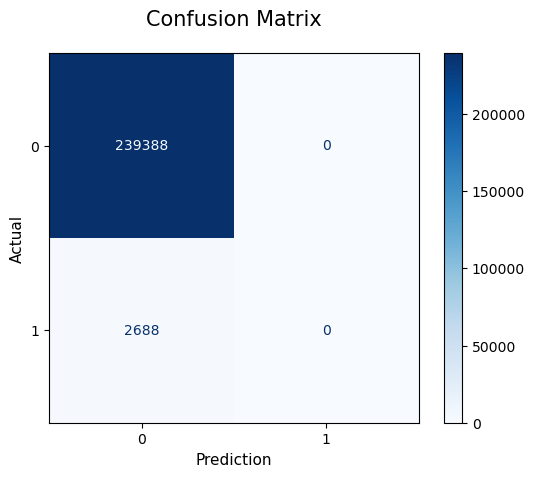

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model.decision_function(X_test_scaled)
y_predict= svm_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC Test ROC Score: ',roc_auc)
print('SVC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Linear SVC with Smote

In [11]:
from sklearn.svm import LinearSVC               # Training time 40s

svm_model_sm = LinearSVC(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote= SMOTE(random_state=42)
    X_train_sm, y_train_sm= smote.fit_resample(X_train,y_train)

    X_train_scaled= scaler.fit_transform(X_train_sm)
    X_val_scaled= scaler.transform(X_val)

    svm_model_sm.fit(X_train_scaled,y_train_sm)
    y_pred= svm_model_sm.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8672692282364014
PR_score: 0.059074085242175264


SVC with Smote Test ROC Score:  0.8471968195237142
SVC with Smote Test PR Score:  0.07449053630759203
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79    239388
         1.0       0.03      0.88      0.05      2688

    accuracy                           0.65    242076
   macro avg       0.51      0.76      0.42    242076
weighted avg       0.99      0.65      0.78    242076



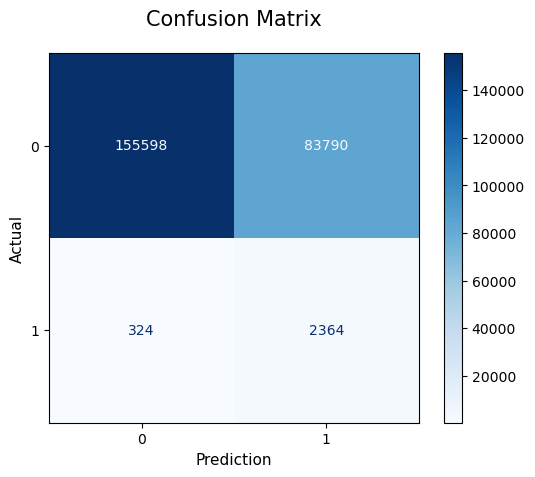

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_sm.decision_function(X_test_scaled)
y_predict= svm_model_sm.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Smote Test ROC Score: ',roc_auc)
print('SVC with Smote Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Linear SVC with RandomOverSampling

In [13]:
svm_model_ovr = LinearSVC(random_state=42)              #Training time 32s
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ovr= RandomOverSampler(random_state=42)
    X_train_ovr, y_train_ovr= ovr.fit_resample(X_train,y_train)

    X_train_scaled= scaler.fit_transform(X_train_ovr)
    X_val_scaled= scaler.transform(X_val)

    svm_model_ovr.fit(X_train_scaled,y_train_ovr)
    y_pred= svm_model_ovr.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.8673046106461447
PR_score: 0.059423731431515026


SVC with Oversampling Test ROC Score:  0.8469942304389089
SVC with Oversampling Test PR Score:  0.07426278762892112
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79    239388
         1.0       0.03      0.88      0.05      2688

    accuracy                           0.65    242076
   macro avg       0.51      0.76      0.42    242076
weighted avg       0.99      0.65      0.78    242076



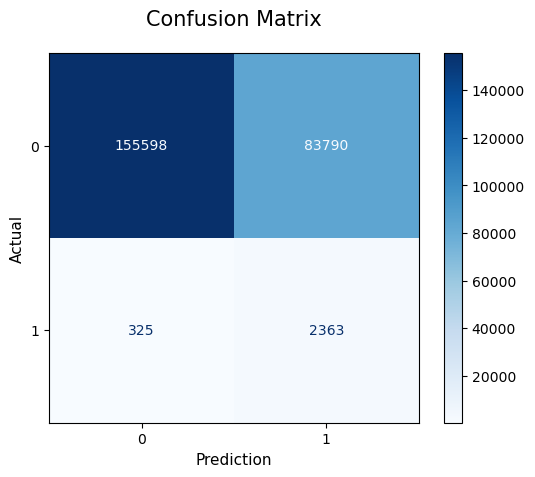

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_ovr.decision_function(X_test_scaled)
y_predict= svm_model_ovr.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Oversampling Test ROC Score: ',roc_auc)
print('SVC with Oversampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Linear SVC with RandomUnderSampling

In [15]:
svm_model_und = LinearSVC(random_state=42)              # Training time 5s
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    und= RandomUnderSampler(random_state=42)
    X_train_und, y_train_und= und.fit_resample(X_train,y_train)

    X_train_scaled= scaler.fit_transform(X_train_und)
    X_val_scaled= scaler.transform(X_val)

    svm_model_und.fit(X_train_scaled,y_train_und)
    y_pred= svm_model_und.decision_function(X_val_scaled) 
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.875891771443081
PR_score: 0.06191841907376181


SVC with Undersampling Test ROC Score:  0.8467298984682765
SVC with Undersampling Test PR Score:  0.07225375465256414
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79    239388
         1.0       0.03      0.88      0.05      2688

    accuracy                           0.65    242076
   macro avg       0.51      0.76      0.42    242076
weighted avg       0.99      0.65      0.78    242076



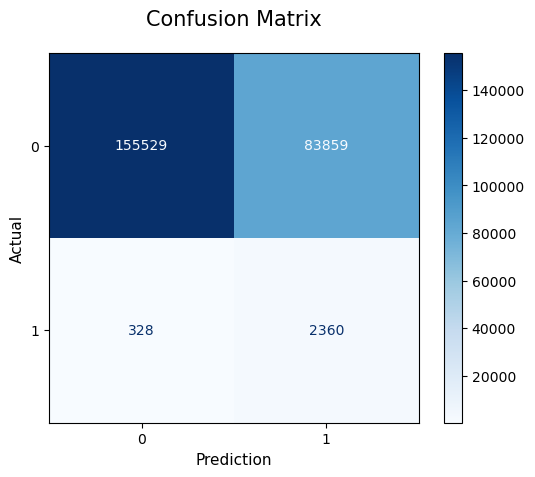

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Since all the sampling techniques resulted in similar but better scores and classification results than normal svc, thus let's perform hyperparameter tuning on Linear SVC with Undersampling.

##### GridSearchCV for LinearSVC with RUS

In [17]:
# Using ROC_AUC for hyperparameter tuning in GridSearchCV

from sklearn.svm import LinearSVC                 

import warnings
warnings.filterwarnings('ignore')

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__loss':['squared_hinge', 'hinge']
}

grid_svm_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_svm_und.fit(X,y)
svm_model_und= grid_svm_und.best_estimator_

best_index= grid_svm_und.best_index_
results = pd.DataFrame(grid_svm_und.cv_results_)

print("Best ROC AUC Score:", grid_svm_und.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_svm_und.best_params_)

Best ROC AUC Score: 0.8849383190449489
Best PR AUC Score: 0.07223269602130643
Best Parameters: {'classifier__C': 1, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


SVC with Undersampling Test ROC Score:  0.871920835817346
SVC with Undersampling Test PR Score:  0.07344262609840138
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89    239388
         1.0       0.04      0.81      0.08      2688

    accuracy                           0.80    242076
   macro avg       0.52      0.81      0.49    242076
weighted avg       0.99      0.80      0.88    242076



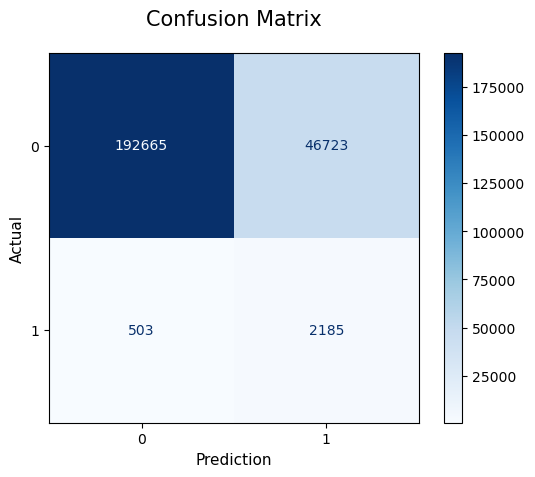

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [19]:
# Using PR_AUC for hyperparameter tuning in GridSearchCV

from sklearn.svm import LinearSVC                 

import warnings
warnings.filterwarnings('ignore')

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=42))
])

param_grid={
    'classifier__penalty':['l1','l2'],
    'classifier__C':[1,0.1,0.01,10],
    'classifier__loss':['squared_hinge', 'hinge']
}

grid_svm_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_svm_und.fit(X,y)
svm_model_und= grid_svm_und.best_estimator_

best_index= grid_svm_und.best_index_
results = pd.DataFrame(grid_svm_und.cv_results_)

print("Best PR AUC Score:", grid_svm_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_svm_und.best_params_)

Best PR AUC Score: 0.07292718792446598
Best ROC AUC Score: 0.8845760709861794
Best Parameters: {'classifier__C': 10, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}


SVC with Undersampling Test ROC Score:  0.875030638333604
SVC with Undersampling Test PR Score:  0.07897256401614436
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90    239388
         1.0       0.05      0.81      0.09      2688

    accuracy                           0.82    242076
   macro avg       0.52      0.81      0.49    242076
weighted avg       0.99      0.82      0.89    242076



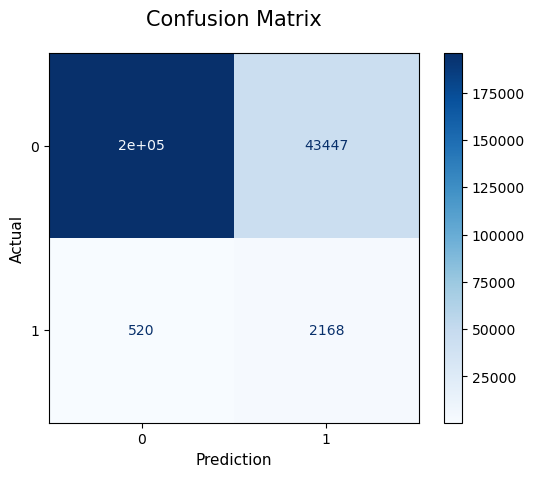

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= svm_model_und.decision_function(X_test_scaled)
y_predict= svm_model_und.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('SVC with Undersampling Test ROC Score: ',roc_auc)
print('SVC with Undersampling Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

As observed both methods resulted in similar scores overall!!

##### GridSearchCV for Decision Tree 

In [21]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 13min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_dt.fit(X,y)
dt_model= grid_dt.best_estimator_

best_index= grid_dt.best_index_
results = pd.DataFrame(grid_dt.cv_results_)

print("Best ROC AUC Score:", grid_dt.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_dt.best_params_)

Best ROC AUC Score: 0.9296581531105336
Best PR AUC Score: 0.14597025485803705
Best Parameters: {'cart__criterion': 'entropy', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


In [22]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 13min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_dt.fit(X,y)
dt_model= grid_dt.best_estimator_

best_index= grid_dt.best_index_
results = pd.DataFrame(grid_dt.cv_results_)

print("Best PR AUC Score:", grid_dt.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_dt.best_params_)

Best PR AUC Score: 0.19094086620949624
Best ROC AUC Score: 0.8526875465677728
Best Parameters: {'cart__criterion': 'gini', 'cart__max_depth': 15, 'cart__max_features': 10, 'cart__min_samples_leaf': 5}


From the above results, the decision tree model with scoring metric as roc performed better but it focuses completely on negative(0) class and neglects positive(1) class so considering tree model with scoring metric as pr as it considers the positive class too. This statement can be verified by looking at the confusion matrix for both conditions, one with pr and one with roc as scoring metric.

So the final parameters for CART model are :- {'cart__criterion': 'gini', 'cart__max_depth': 15, 'cart__max_features': 10, 'cart__min_samples_leaf': 1}

The test performance of cart model are as follows:-

CART Test ROC Score:  0.7378085843541408
CART Test PR Score:  0.09219210375071771
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.19      0.04      0.06      2688

    accuracy                           0.99    242076
   macro avg       0.59      0.52      0.53    242076
weighted avg       0.98      0.99      0.98    242076



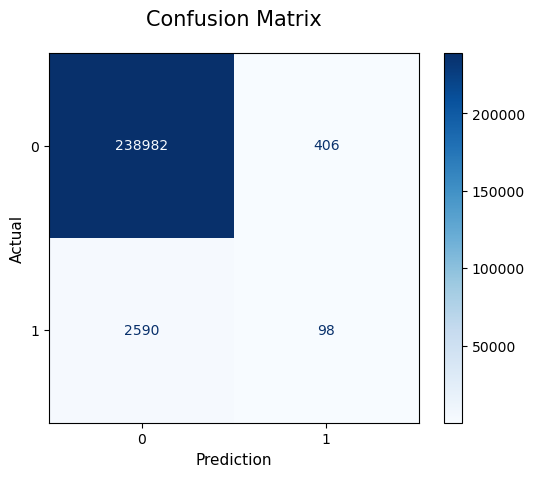

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

_  = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

y_pred= dt_model.predict_proba(X_test_scaled)[:, 1]
y_predict= dt_model.predict(X_test_scaled)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('CART Test ROC Score: ',roc_auc)
print('CART Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Decision Tree with RUS

In [24]:
dt_model_rus= DecisionTreeClassifier(random_state=42)        

roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    dt_model_rus.fit(X_train_und,y_train_und)
    y_pred= dt_model_rus.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')
print(f'PR_scorelist: {pr_score}')

Roc_score: 0.8683199298191477
PR_score: 0.4472980510456196
PR_scorelist: [0.4485517836628623, 0.44983440079890724, 0.4409247630198734, 0.4515321392651579, 0.4456471684812971]


CART RUS Test ROC Score:  0.7974165401225008
CART RUS Test PR Score:  0.3882089649646395
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    239388
         1.0       0.06      0.72      0.11      2688

    accuracy                           0.87    242076
   macro avg       0.53      0.79      0.52    242076
weighted avg       0.99      0.87      0.92    242076



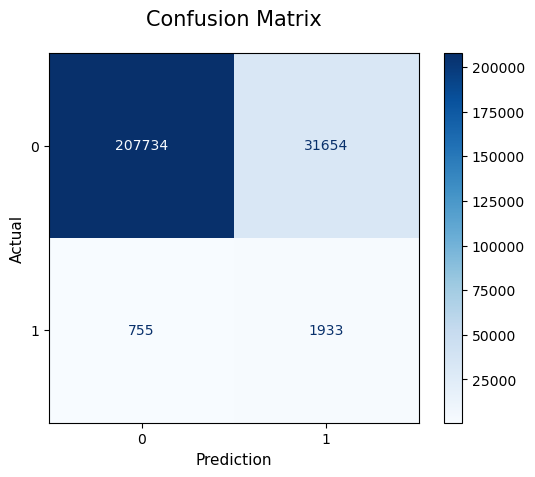

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= dt_model_rus.predict_proba(X_test)[:, 1]
y_predict= dt_model_rus.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('CART RUS Test ROC Score: ',roc_auc)
print('CART RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Decision Tree with RUS

In [26]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 3min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt_rus= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_dt_rus.fit(X,y)
dt_model_rus= grid_dt_rus.best_estimator_

best_index= grid_dt_rus.best_index_
results = pd.DataFrame(grid_dt_rus.cv_results_)

print("Best ROC AUC Score:", grid_dt_rus.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_dt_rus.best_params_)

Best ROC AUC Score: 0.9280666681113953
Best PR AUC Score: 0.09935001789917675
Best Parameters: {'cart__criterion': 'entropy', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


In [27]:
# Using PR_AUC as the scoring metric during GridSearchCV            
# Training time 3min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('cart', DecisionTreeClassifier(random_state=42))
])

param_grid={
    'cart__max_depth':[3,4,5,7,10,15,20,30,50],
    'cart__max_features':[3,5,10,None],
    'cart__criterion': ['entropy','gini'],
    'cart__min_samples_leaf':[1,5]
}

grid_dt_rus= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_dt_rus.fit(X,y)
dt_model_rus= grid_dt_rus.best_estimator_

best_index= grid_dt_rus.best_index_
results = pd.DataFrame(grid_dt_rus.cv_results_)

print("Best PR AUC Score:", grid_dt_rus.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_dt_rus.best_params_)

Best PR AUC Score: 0.10298058317502676
Best ROC AUC Score: 0.9267319325947107
Best Parameters: {'cart__criterion': 'gini', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}


Both showed similar results!! 

So the final parameters for Decision Tree with RUS are:- {'cart__criterion': 'gini', 'cart__max_depth': 7, 'cart__max_features': None, 'cart__min_samples_leaf': 5}

The test performance for the CART model with RUS are as follows:-

CART RUS Test ROC Score:  0.9112452325727232
CART RUS Test PR Score:  0.12997254917141926
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94    239388
         1.0       0.07      0.81      0.13      2688

    accuracy                           0.88    242076
   macro avg       0.54      0.84      0.54    242076
weighted avg       0.99      0.88      0.93    242076



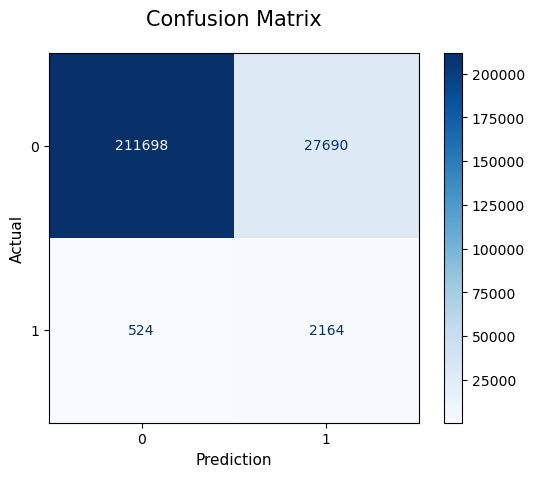

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= dt_model_rus.predict_proba(X_test)[:, 1]
y_predict= dt_model_rus.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('CART RUS Test ROC Score: ',roc_auc)
print('CART RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Random Forest

In [29]:
rforest_model = RandomForestClassifier(random_state=42)         # Training time 15min    
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    rforest_model.fit(X_train,y_train)
    y_pred= rforest_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')
print(f'PR_score: {pr_score}')

Roc_score: 0.9287372077067447
PR_score: 0.4071979191195685
PR_score: [0.4189642220566472, 0.3949204663643457, 0.4122328035169832, 0.39675327956056416, 0.4131188240993023]


Random Forest Test ROC Score:  0.7793550715161958
Random Forest Test PR Score:  0.15571753564074742
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.37      0.03      0.05      2688

    accuracy                           0.99    242076
   macro avg       0.68      0.51      0.52    242076
weighted avg       0.98      0.99      0.98    242076



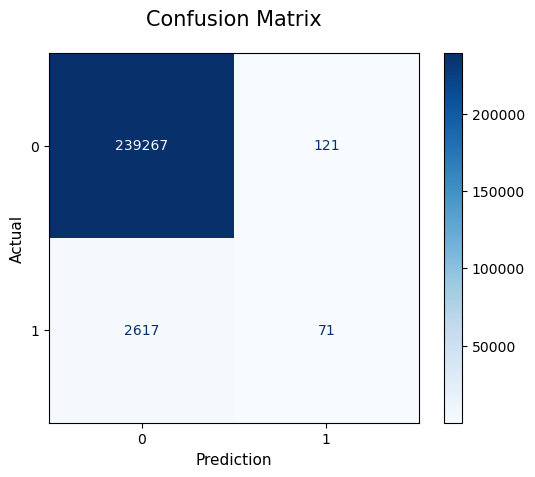

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rforest_model.predict_proba(X_test)[:, 1]
y_predict= rforest_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest Test ROC Score: ',roc_auc)
print('Random Forest Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Random Forest 

In [31]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 8min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_rf.fit(X,y)
rf_model= grid_rf.best_estimator_

best_index= grid_rf.best_index_
results = pd.DataFrame(grid_rf.cv_results_)

print("Best ROC AUC Score:", grid_rf.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_rf.best_params_)

Best ROC AUC Score: 0.9560017269134861
Best PR AUC Score: 0.26305634716234627
Best Parameters: {'forest__criterion': 'entropy', 'forest__max_depth': 20}


Random Forest Test ROC Score:  0.9053868288615137
Random Forest Test PR Score:  0.2229009760067679
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.74      0.01      0.01      2688

    accuracy                           0.99    242076
   macro avg       0.86      0.50      0.50    242076
weighted avg       0.99      0.99      0.98    242076



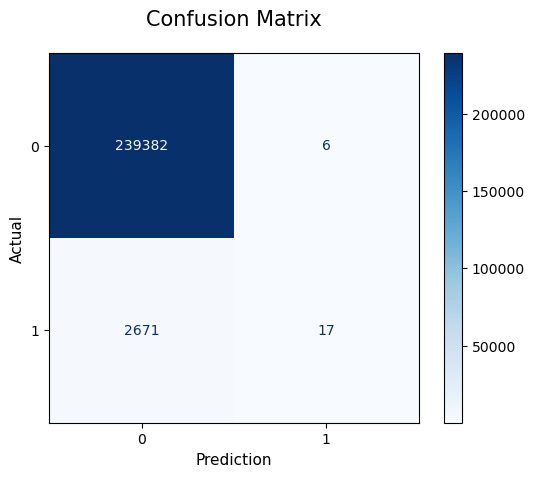

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model.predict_proba(X_test)[:, 1]
y_predict= rf_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest Test ROC Score: ',roc_auc)
print('Random Forest Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

A similar score was obtained for pr metric too

##### GridSearchCV for Random Forest with Smote

model performed slightly better for roc as scoring metric 

In [33]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 24min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('smote',SMOTE(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_sm= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_rf_sm.fit(X,y)
rf_model_sm= grid_rf_sm.best_estimator_

best_index= grid_rf_sm.best_index_
results = pd.DataFrame(grid_rf_sm.cv_results_)

print("Best ROC AUC Score:", grid_rf_sm.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_rf_sm.best_params_)

Best ROC AUC Score: 0.9512472305279918
Best PR AUC Score: 0.23663442352583658
Best Parameters: {'forest__criterion': 'gini', 'forest__max_depth': 30}


Random Forest with Smote Test ROC Score:  0.8926985655870386
Random Forest with Smote Test PR Score:  0.15055130183048798
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    239388
         1.0       0.16      0.41      0.23      2688

    accuracy                           0.97    242076
   macro avg       0.58      0.69      0.61    242076
weighted avg       0.98      0.97      0.98    242076



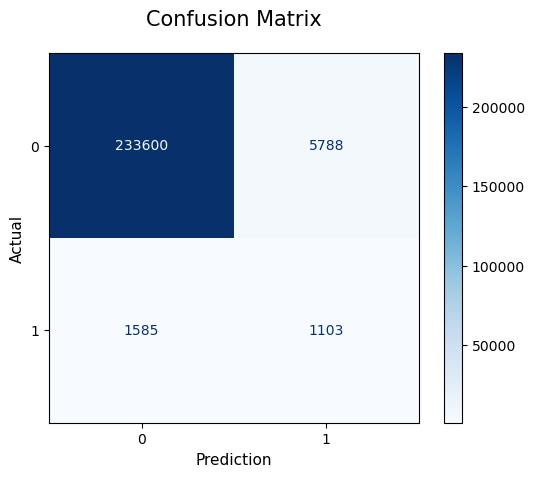

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model_sm.predict_proba(X_test)[:, 1]
y_predict= rf_model_sm.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with Smote Test ROC Score: ',roc_auc)
print('Random Forest with Smote Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Random Forest with RUS

In [35]:
# Using ROC_AUC as the scoring metric during GridSearchCV            
# Training time 41s

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_rf_und.fit(X,y)
rf_model_und= grid_rf_und.best_estimator_

best_index= grid_rf_und.best_index_
results = pd.DataFrame(grid_rf_und.cv_results_)

print("Best ROC AUC Score:", grid_rf_und.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_rf_und.best_params_)

Best ROC AUC Score: 0.9446494840989714
Best PR AUC Score: 0.14639646993002942
Best Parameters: {'forest__criterion': 'gini', 'forest__max_depth': 50}


Random Forest with RUS Test ROC Score:  0.9210344769850122
Random Forest with RUS Test PR Score:  0.18152941927673205
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    239388
         1.0       0.07      0.81      0.14      2688

    accuracy                           0.89    242076
   macro avg       0.54      0.85      0.54    242076
weighted avg       0.99      0.89      0.93    242076



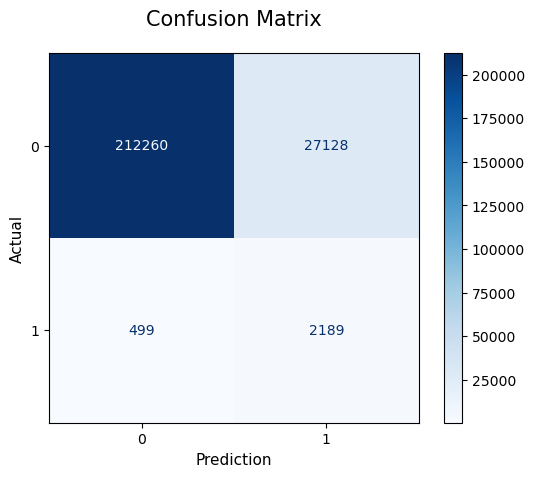

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model_und.predict_proba(X_test)[:, 1]
y_predict= rf_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with RUS Test ROC Score: ',roc_auc)
print('Random Forest with RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [37]:
# Using PR_AUC as the scoring metric during GridSearchCV            
# Training time 41s

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('undersamp',RandomUnderSampler(random_state=42)),
    ('forest', RandomForestClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'forest__max_depth':[3,4,5,7,10,15,20,30,50],
    'forest__criterion':['gini','entropy']
}

grid_rf_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_rf_und.fit(X,y)
rf_model_und= grid_rf_und.best_estimator_

best_index= grid_rf_und.best_index_
results = pd.DataFrame(grid_rf_und.cv_results_)

print("Best PR AUC Score:", grid_rf_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_rf_und.best_params_)

Best PR AUC Score: 0.15004278957553674
Best ROC AUC Score: 0.9425049024615431
Best Parameters: {'forest__criterion': 'entropy', 'forest__max_depth': 15}


Random Forest with RUS Test ROC Score:  0.921859052992124
Random Forest with RUS Test PR Score:  0.17407308379253478
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93    239388
         1.0       0.07      0.82      0.13      2688

    accuracy                           0.88    242076
   macro avg       0.53      0.85      0.53    242076
weighted avg       0.99      0.88      0.92    242076



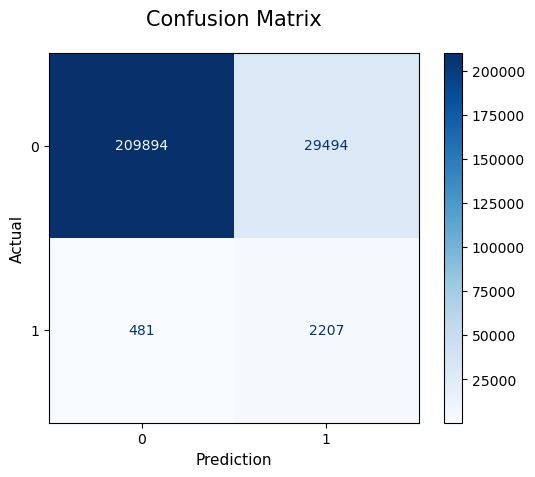

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rf_model_und.predict_proba(X_test)[:, 1]
y_predict= rf_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Random Forest with RUS Test ROC Score: ',roc_auc)
print('Random Forest with RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Similar performance shown by both scoring metrics!!

##### GridSearchCV for Gradient Boosting Model

In [39]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 60min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb.fit(X,y)
gb_model= grid_gb.best_estimator_

best_index= grid_gb.best_index_
results = pd.DataFrame(grid_gb.cv_results_)

print("Best ROC AUC Score:", grid_gb.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_gb.best_params_)

Best ROC AUC Score: 0.9425292148318836
Best PR AUC Score: 0.19217649429950118
Best Parameters: {'gboost__max_depth': 10}


GBoost Test ROC Score:  0.9207455286712765
GBoost Test PR Score:  0.19461789506164784
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.41      0.08      0.13      2688

    accuracy                           0.99    242076
   macro avg       0.70      0.54      0.56    242076
weighted avg       0.98      0.99      0.98    242076



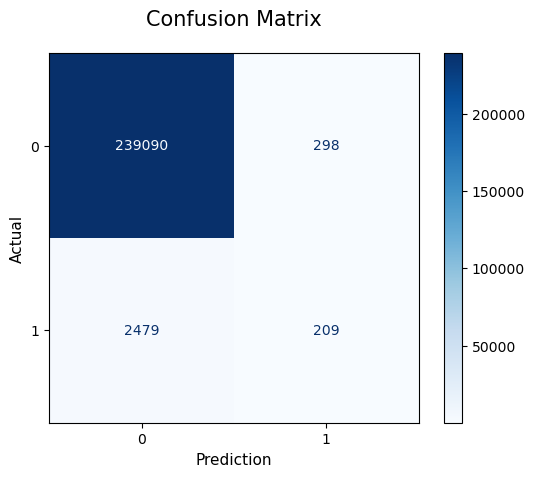

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model.predict_proba(X_test)[:, 1]
y_predict= gb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost Test ROC Score: ',roc_auc)
print('GBoost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [ ]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 73min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb.fit(X,y)
gb_model= grid_gb.best_estimator_

best_index= grid_gb.best_index_
results = pd.DataFrame(grid_gb.cv_results_)

print("Best PR AUC Score:", grid_gb.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_gb.best_params_)

Best PR AUC Score: 0.2266388637222275
Best ROC AUC Score: 0.8141824941914579
Best Parameters: {'gboost__max_depth': 50}


GBoost Test ROC Score:  0.6116926419127208
GBoost Test PR Score:  0.09187637859158442
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.27      0.09      0.14      2688

    accuracy                           0.99    242076
   macro avg       0.63      0.54      0.56    242076
weighted avg       0.98      0.99      0.98    242076



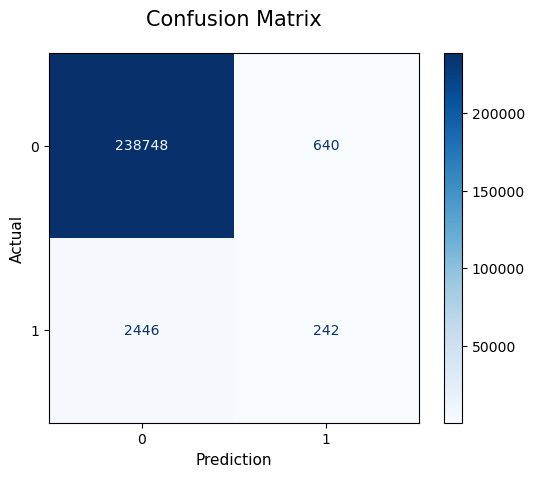

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model.predict_proba(X_test)[:, 1]
y_predict= gb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost Test ROC Score: ',roc_auc)
print('GBoost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Gradient Boosting with roc as scoring metric is showing better performance but pr scoring metric is better when predicting positive class. 

##### GridSearchCV for Gradient Boost with RUS

In [43]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 1min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('rus',RandomUnderSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb_und.fit(X,y)
gb_model_und= grid_gb_und.best_estimator_

best_index= grid_gb_und.best_index_
results = pd.DataFrame(grid_gb_und.cv_results_)

print("Best ROC AUC Score:", grid_gb_und.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_gb_und.best_params_)

Best ROC AUC Score: 0.9447159910328441
Best PR AUC Score: 0.12927641387830463
Best Parameters: {'gboost__max_depth': 10}


GBoost RUS Test ROC Score:  0.9157471304741277
GBoost RUS Test PR Score:  0.1644236256212731
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    239388
         1.0       0.07      0.81      0.14      2688

    accuracy                           0.89    242076
   macro avg       0.54      0.85      0.54    242076
weighted avg       0.99      0.89      0.93    242076



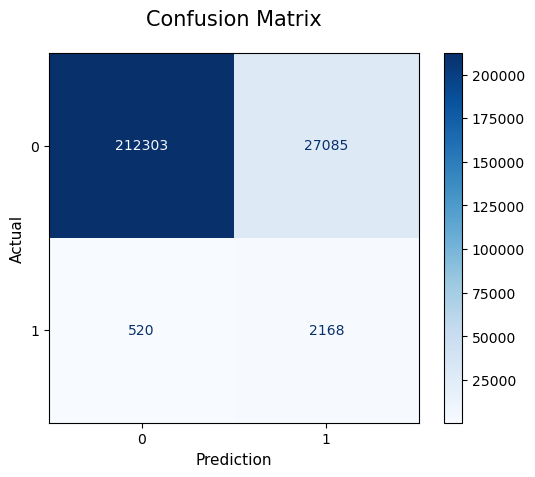

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_und.predict_proba(X_test)[:, 1]
y_predict= gb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost RUS Test ROC Score: ',roc_auc)
print('GBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [45]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 1min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('rus',RandomUnderSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_und= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb_und.fit(X,y)
gb_model_und= grid_gb_und.best_estimator_

best_index= grid_gb_und.best_index_
results = pd.DataFrame(grid_gb_und.cv_results_)

print("Best PR AUC Score:", grid_gb_und.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_gb_und.best_params_)

Best PR AUC Score: 0.1488697285157788
Best ROC AUC Score: 0.9401107257952429
Best Parameters: {'gboost__max_depth': 7}


GBoost RUS Test ROC Score:  0.9227304971800113
GBoost RUS Test PR Score:  0.18708135762528738
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    239388
         1.0       0.07      0.82      0.14      2688

    accuracy                           0.88    242076
   macro avg       0.54      0.85      0.54    242076
weighted avg       0.99      0.88      0.93    242076



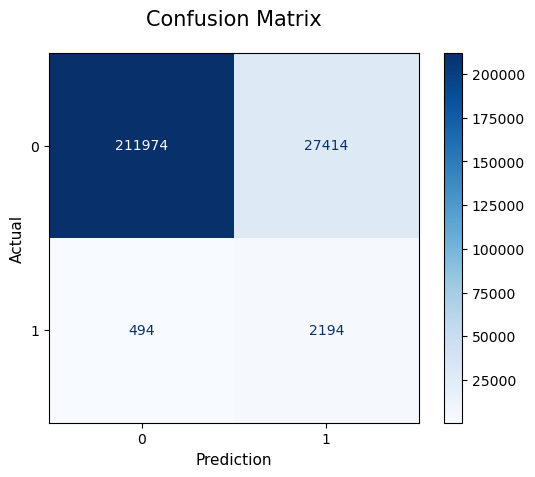

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_und.predict_proba(X_test)[:, 1]
y_predict= gb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost RUS Test ROC Score: ',roc_auc)
print('GBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Similar performance shown by both scoring metric

##### GridSearchCV for Gradient Boost with ROS

In [ ]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 96min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('oversamp',RandomOverSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_ovr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_gb_ovr.fit(X,y)
gb_model_ovr= grid_gb_ovr.best_estimator_

best_index= grid_gb_ovr.best_index_
results = pd.DataFrame(grid_gb_ovr.cv_results_)

print("Best PR AUC Score:", grid_gb_ovr.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_gb_ovr.best_params_)

Best PR AUC Score: 0.21572679634010622
Best ROC AUC Score: 0.8876590829838753
Best Parameters: {'gboost__max_depth': 20}


GBoost ROS Test ROC Score:  0.7918835818726144
GBoost ROS Test PR Score:  0.12882668124598495
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98    239388
         1.0       0.12      0.45      0.18      2688

    accuracy                           0.96    242076
   macro avg       0.55      0.71      0.58    242076
weighted avg       0.98      0.96      0.97    242076



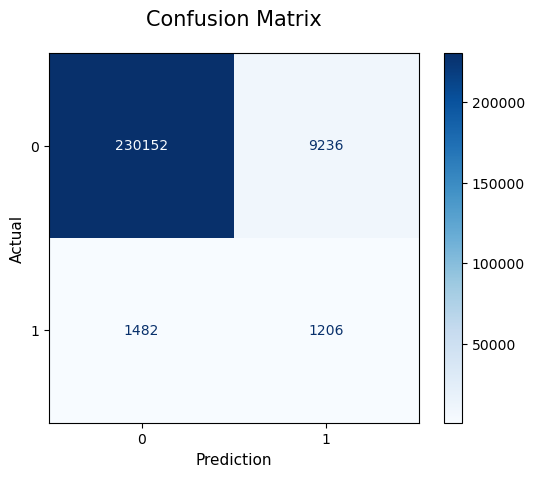

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= gb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost ROS Test ROC Score: ',roc_auc)
print('GBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [ ]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 88min

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('oversamp',RandomOverSampler(random_state=42)),
    ('gboost', GradientBoostingClassifier(n_estimators=10,min_samples_leaf=5,random_state=42))
])

param_grid={
    'gboost__max_depth':[3,4,5,7,10,15,20,30,50]
}

grid_gb_ovr= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_gb_ovr.fit(X,y)
gb_model_ovr= grid_gb_ovr.best_estimator_

best_index= grid_gb_ovr.best_index_
results = pd.DataFrame(grid_gb_ovr.cv_results_)

print("Best ROC AUC Score:", grid_gb_ovr.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_gb_ovr.best_params_)

Best ROC AUC Score: 0.9473541498204365
Best PR AUC Score: 0.17818650074600212
Best Parameters: {'gboost__max_depth': 10}


GBoost ROS Test ROC Score:  0.9133224564218619
GBoost ROS Test PR Score:  0.2193228150990134
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95    239388
         1.0       0.09      0.77      0.16      2688

    accuracy                           0.91    242076
   macro avg       0.54      0.84      0.55    242076
weighted avg       0.99      0.91      0.94    242076



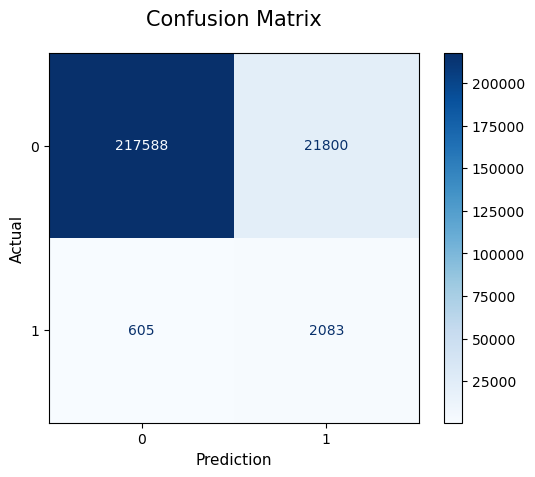

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= gb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= gb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('GBoost ROS Test ROC Score: ',roc_auc)
print('GBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

ROC Scoring metric performed better than Pr metric!!

##### XGBoost model

In [51]:
import xgboost as xgb                               # Training time 33s

xgb_model = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    xgb_model.fit(X_train,y_train)
    y_pred= xgb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9545517466276907
PR_score: 0.2627127245981948


XGBoost Test ROC Score:  0.9251200952744478
XGBoost Test PR Score:  0.22110622883047484
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.55      0.02      0.03      2688

    accuracy                           0.99    242076
   macro avg       0.77      0.51      0.51    242076
weighted avg       0.98      0.99      0.98    242076



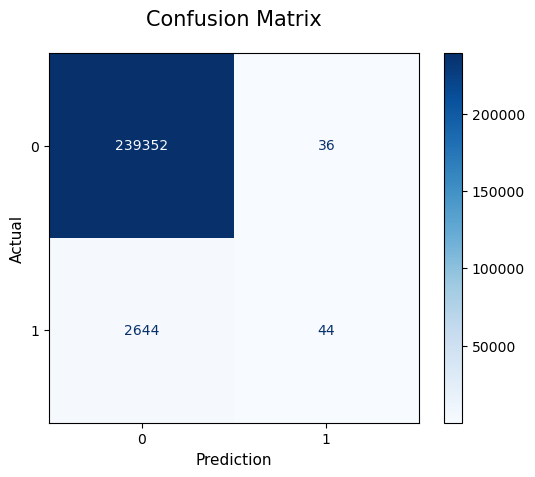

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model.predict_proba(X_test)[:, 1]
y_predict= xgb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost Test ROC Score: ',roc_auc)
print('XGBoost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### XGBoost with Smote

In [53]:
xgb_model_sm = xgb.XGBClassifier(random_state=42)                       # Train time 2min
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    smote = SMOTE(random_state=42)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    xgb_model_sm.fit(X_train_sm,y_train_sm)
    y_pred= xgb_model_sm.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9405911733182833
PR_score: 0.15793388482842818


XGBoost Smote Test ROC Score:  0.9051364135166698
XGBoost Smote Test PR Score:  0.1643969419473962
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98    239388
         1.0       0.14      0.53      0.22      2688

    accuracy                           0.96    242076
   macro avg       0.57      0.75      0.60    242076
weighted avg       0.99      0.96      0.97    242076



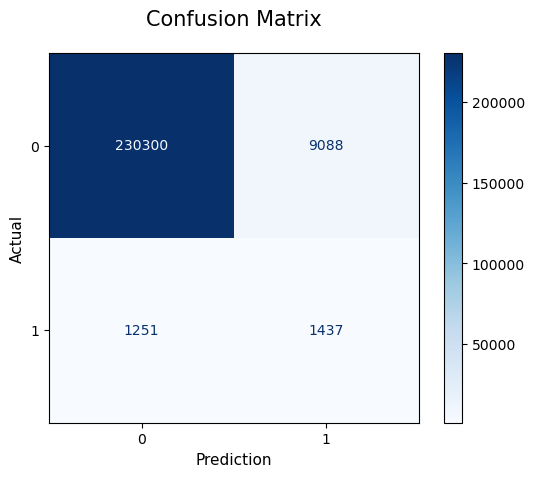

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model_sm.predict_proba(X_test)[:, 1]
y_predict= xgb_model_sm.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost Smote Test ROC Score: ',roc_auc)
print('XGBoost Smote Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### XGBoost with ROS

In [55]:
import xgboost as xgb                               # Training time 1min

xgb_model_ovr = xgb.XGBClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ovr= RandomOverSampler(random_state=42)
    X_train_ovr,y_train_ovr= ovr.fit_resample(X_train,y_train)

    xgb_model_ovr.fit(X_train_ovr,y_train_ovr)
    y_pred= xgb_model_ovr.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9559880590893176
PR_score: 0.22826683203200165


XGBoost ROS Test ROC Score:  0.9123614858265562
XGBoost ROS Test PR Score:  0.21534617476330453
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    239388
         1.0       0.09      0.74      0.16      2688

    accuracy                           0.91    242076
   macro avg       0.54      0.83      0.56    242076
weighted avg       0.99      0.91      0.95    242076



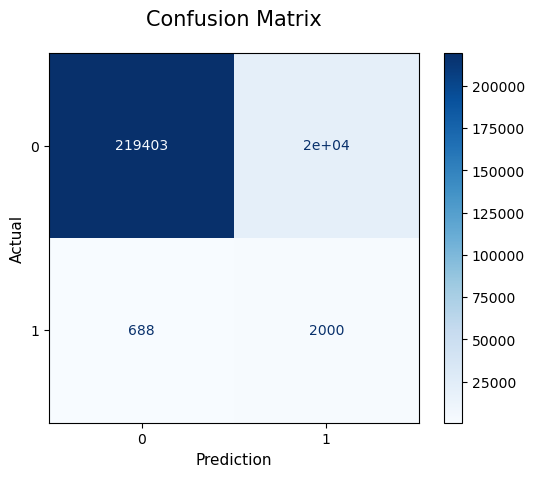

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model_ovr.predict_proba(X_test)[:, 1]
y_predict= xgb_model_ovr.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost ROS Test ROC Score: ',roc_auc)
print('XGBoost ROS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### XGBoost with RUS

In [57]:
xgb_model_und = xgb.XGBClassifier(random_state=42)                  # Train time 4s
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    ran_under = RandomUnderSampler(random_state=42)
    X_train_und, y_train_und = ran_under.fit_resample(X_train, y_train)

    xgb_model_und.fit(X_train_und,y_train_und)
    y_pred= xgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9515554484901072
PR_score: 0.15621331454397697


XGBoost RUS Test ROC Score:  0.9205914022349253
XGBoost RUS Test PR Score:  0.17945952437779217
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    239388
         1.0       0.08      0.80      0.14      2688

    accuracy                           0.89    242076
   macro avg       0.54      0.85      0.54    242076
weighted avg       0.99      0.89      0.93    242076



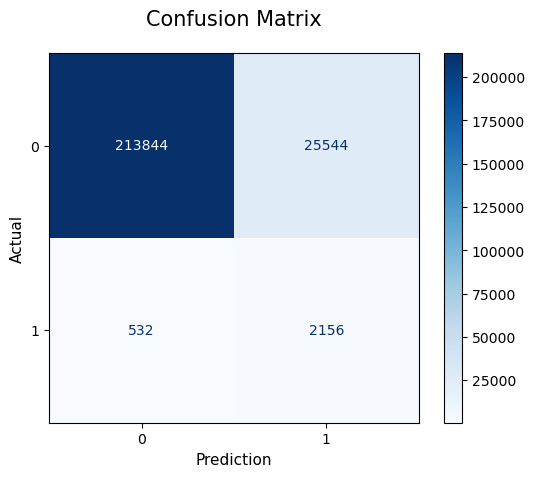

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= xgb_model_und.predict_proba(X_test)[:, 1]
y_predict= xgb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('XGBoost RUS Test ROC Score: ',roc_auc)
print('XGBoost RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### LightGBM

In [59]:
import lightgbm as lgb                          # Training time 27s

lgb_model = lgb.LGBMClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    lgb_model.fit(X_train,y_train)
    y_pred= lgb_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

[LightGBM] [Info] Number of positive: 9034, number of negative: 1341254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 1350288, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006690 -> initscore=-5.000365
[LightGBM] [Info] Start training from score -5.000365
[LightGBM] [Info] Number of positive: 9035, number of negative: 1341254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 1350289, number of used features: 15
[LightGBM] [

LGBM Test ROC Score:  0.9141597664135311
LGBM Test PR Score:  0.17141312301950806
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    239388
         1.0       0.33      0.06      0.11      2688

    accuracy                           0.99    242076
   macro avg       0.66      0.53      0.55    242076
weighted avg       0.98      0.99      0.98    242076



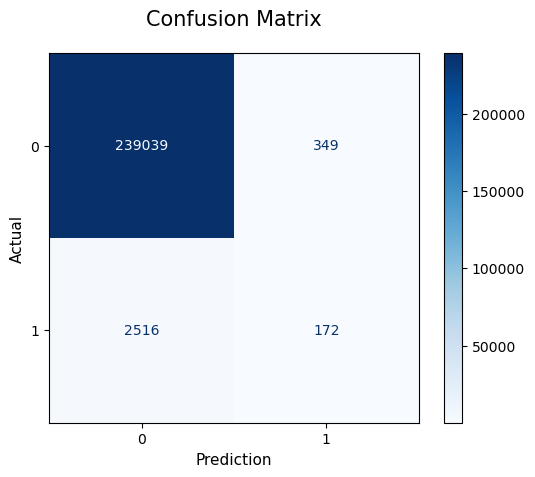

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= lgb_model.predict_proba(X_test)[:, 1]
y_predict= lgb_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('LGBM Test ROC Score: ',roc_auc)
print('LGBM Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### LightGBM with RUS

In [61]:
import lightgbm as lgb                          # Training time 7s

lgb_model_und = lgb.LGBMClassifier(random_state=42)
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    und= RandomUnderSampler(random_state=42)
    X_train_und,y_train_und= und.fit_resample(X_train,y_train)

    lgb_model_und.fit(X_train_und,y_train_und)
    y_pred= lgb_model_und.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

[LightGBM] [Info] Number of positive: 9034, number of negative: 9034
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 18068, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 9035, number of negative: 9035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1417
[LightGBM] [Info] Number of data points in the train set: 18070, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

LGBM RUS Test ROC Score:  0.927334660912609
LGBM RUS Test PR Score:  0.19604750952415928
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    239388
         1.0       0.08      0.83      0.14      2688

    accuracy                           0.89    242076
   macro avg       0.54      0.86      0.54    242076
weighted avg       0.99      0.89      0.93    242076



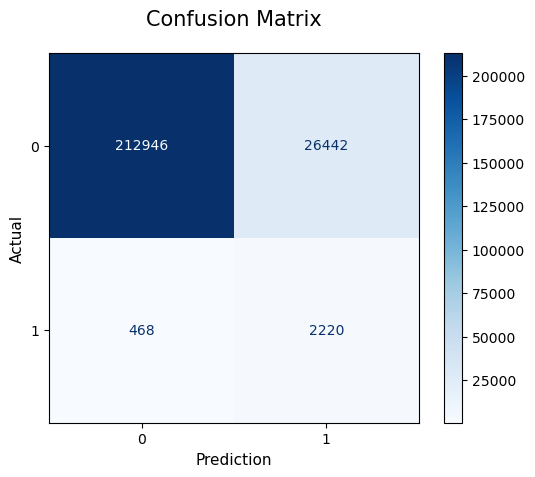

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= lgb_model_und.predict_proba(X_test)[:, 1]
y_predict= lgb_model_und.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('LGBM RUS Test ROC Score: ',roc_auc)
print('LGBM RUS Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### Balanced Bagging

In [63]:
from imblearn.ensemble import BalancedBaggingClassifier                 #Training time 26s

bbc_model = BalancedBaggingClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    bbc_model.fit(X_train,y_train)
    y_pred= bbc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9535763072920455
PR_score: 0.29971461042629627


BBC Test ROC Score:  0.9028470718511769
BBC Test PR Score:  0.2338786345080708
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    239388
         1.0       0.09      0.71      0.16      2688

    accuracy                           0.92    242076
   macro avg       0.54      0.81      0.56    242076
weighted avg       0.99      0.92      0.95    242076



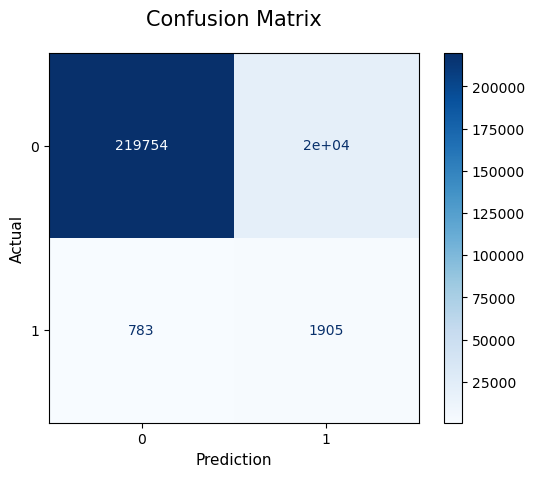

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= bbc_model.predict_proba(X_test)[:, 1]
y_predict= bbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BBC Test ROC Score: ',roc_auc)
print('BBC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### GridSearchCV for Balanced Bagging

In [65]:
# Using ROC_AUC as the scoring metric during GridSearchCV
# Training time 20min

from imblearn.ensemble import BalancedBaggingClassifier

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('bbc', BalancedBaggingClassifier(random_state=42))
])

param_grid={
    'bbc__n_estimators':[10,50,100,200,500]
}

grid_bbc= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='roc_auc',n_jobs=-1)
grid_bbc.fit(X,y)
bbc_model= grid_bbc.best_estimator_

best_index= grid_bbc.best_index_
results = pd.DataFrame(grid_bbc.cv_results_)

print("Best ROC AUC Score:", grid_bbc.best_score_)  # Best estimator's ROC AUC (used for refit)
print("Best PR AUC Score:", results['mean_test_pr_auc'][best_index])   # Best estimator's PR score
print("Best Parameters:", grid_bbc.best_params_)

Best ROC AUC Score: 0.9638497949749688
Best PR AUC Score: 0.2768497183926259
Best Parameters: {'bbc__n_estimators': 500}


BBC Test ROC Score:  0.918624055235941
BBC Test PR Score:  0.1977800697837564
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    239388
         1.0       0.09      0.75      0.16      2688

    accuracy                           0.92    242076
   macro avg       0.54      0.83      0.56    242076
weighted avg       0.99      0.92      0.95    242076



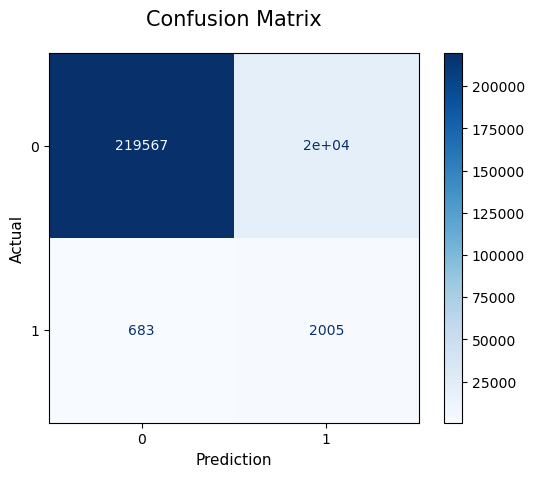

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= bbc_model.predict_proba(X_test)[:, 1]
y_predict= bbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BBC Test ROC Score: ',roc_auc)
print('BBC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

In [67]:
# Using PR_AUC as the scoring metric during GridSearchCV
# Training time 20min

from imblearn.ensemble import BalancedBaggingClassifier

scoring = {'pr_auc': 'average_precision', 'roc_auc': 'roc_auc'}

pipeline = Pipeline(steps=[
    ('bbc', BalancedBaggingClassifier(random_state=42))
])

param_grid={
    'bbc__n_estimators':[10,50,100,200,500]
}

grid_bbc= GridSearchCV(pipeline,param_grid=param_grid,cv=skf,scoring=scoring,refit='pr_auc',n_jobs=-1)
grid_bbc.fit(X,y)
bbc_model= grid_bbc.best_estimator_

best_index= grid_bbc.best_index_
results = pd.DataFrame(grid_bbc.cv_results_)

print("Best PR AUC Score:", grid_bbc.best_score_)  # Best estimator's PR AUC (used for refit)
print("Best ROC AUC Score:", results['mean_test_roc_auc'][best_index])   # Best estimator's ROC score
print("Best Parameters:", grid_bbc.best_params_)

Best PR AUC Score: 0.2768497183926259
Best ROC AUC Score: 0.9638497949749688
Best Parameters: {'bbc__n_estimators': 500}


BBC Test ROC Score:  0.918624055235941
BBC Test PR Score:  0.1977800697837564
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    239388
         1.0       0.09      0.75      0.16      2688

    accuracy                           0.92    242076
   macro avg       0.54      0.83      0.56    242076
weighted avg       0.99      0.92      0.95    242076



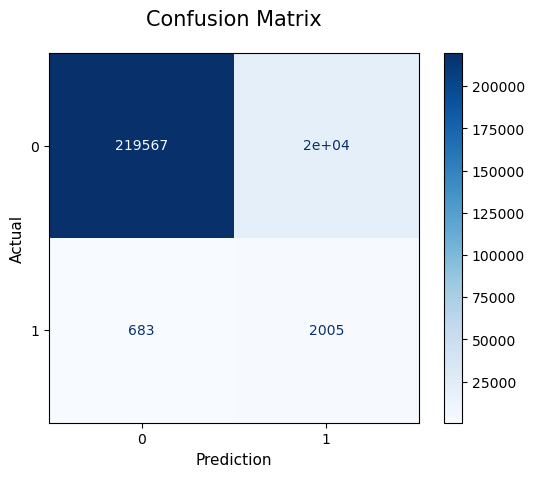

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= bbc_model.predict_proba(X_test)[:, 1]
y_predict= bbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BBC Test ROC Score: ',roc_auc)
print('BBC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

Similar performance was shown by both scoring metric!!

##### Balanced Random Forest

In [69]:
from imblearn.ensemble import BalancedRandomForestClassifier                # Training time 4min

brfc_model = BalancedRandomForestClassifier(n_estimators=200,bootstrap=True,replacement=False,sampling_strategy='auto',random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    brfc_model.fit(X_train,y_train)
    y_pred= brfc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9650024981844846
PR_score: 0.27706512434491143


BRFC Test ROC Score:  0.9216926696682692
BRFC Test PR Score:  0.18664554452332152
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    239388
         1.0       0.08      0.81      0.14      2688

    accuracy                           0.89    242076
   macro avg       0.54      0.85      0.54    242076
weighted avg       0.99      0.89      0.93    242076



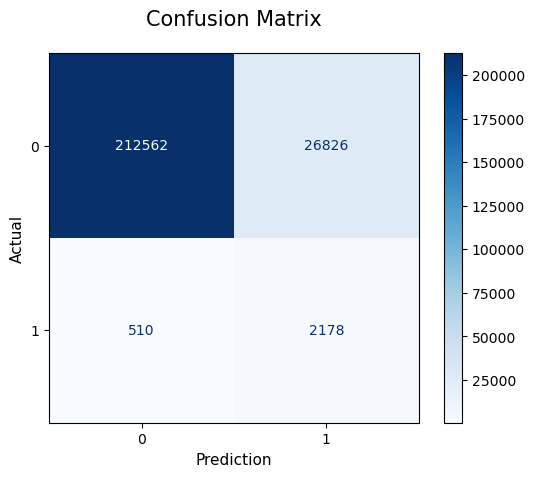

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= brfc_model.predict_proba(X_test)[:, 1]
y_predict= brfc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('BRFC Test ROC Score: ',roc_auc)
print('BRFC Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### RUS Boosting

In [71]:
from imblearn.ensemble import RUSBoostClassifier                        #Training time 2min

rusbc_model = RUSBoostClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    rusbc_model.fit(X_train,y_train)
    y_pred= rusbc_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9276736151489267
PR_score: 0.1375771351522467


RUS Boost Test ROC Score:  0.9143660129834053
RUS Boost Test PR Score:  0.16689953902092325
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    239388
         1.0       0.06      0.83      0.12      2688

    accuracy                           0.86    242076
   macro avg       0.53      0.84      0.52    242076
weighted avg       0.99      0.86      0.92    242076



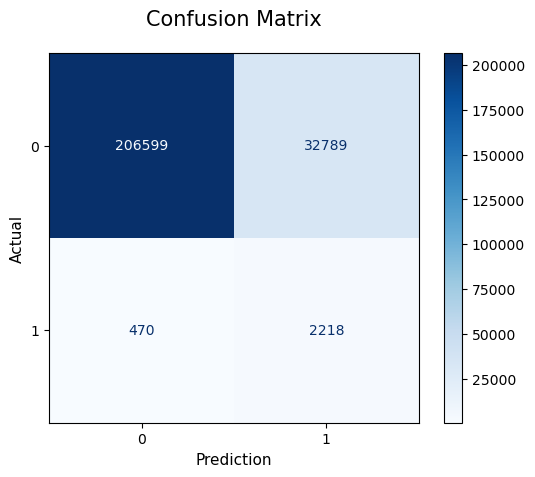

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= rusbc_model.predict_proba(X_test)[:, 1]
y_predict= rusbc_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('RUS Boost Test ROC Score: ',roc_auc)
print('RUS Boost Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))

##### EasyEnsemble

In [73]:
from imblearn.ensemble import EasyEnsembleClassifier                        #Training Time 2min

eec_model = EasyEnsembleClassifier(random_state=42)           
roc_score= []
pr_score= []

for train_index, val_index in skf.split(X,y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    eec_model.fit(X_train,y_train)
    y_pred= eec_model.predict_proba(X_val)[:, 1]  
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    auc_score = auc(recall, precision)
    pr_score.append(auc_score)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_score.append(roc_auc)

print(f'Roc_score: {sum(roc_score)/len(roc_score)}')
print(f'PR_score: {sum(pr_score)/len(pr_score)}')

Roc_score: 0.9260260050456932
PR_score: 0.1324069325769889


EasyEnsemble Test ROC Score:  0.9155200695739911
EasyEnsemble Test PR Score:  0.1672883749902781
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    239388
         1.0       0.07      0.83      0.12      2688

    accuracy                           0.87    242076
   macro avg       0.53      0.85      0.53    242076
weighted avg       0.99      0.87      0.92    242076



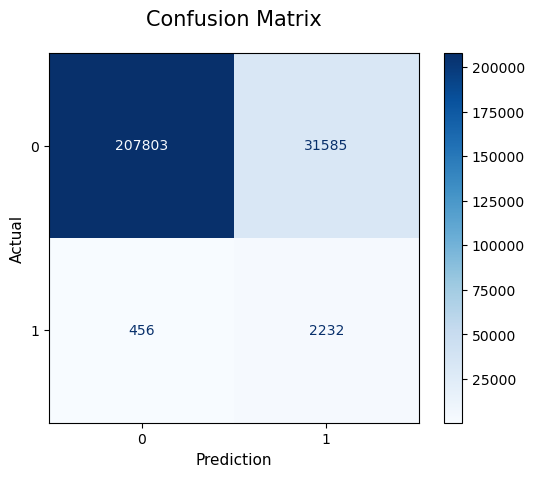

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred= eec_model.predict_proba(X_test)[:, 1]
y_predict= eec_model.predict(X_test)
    
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('EasyEnsemble Test ROC Score: ',roc_auc)
print('EasyEnsemble Test PR Score: ',pr_auc)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

print(classification_report(y_test,y_predict))